<a href="https://colab.research.google.com/github/GabrielaGuestory/MachineLearning/blob/main/sistema_de_detec%C3%A7%C3%A3o_e_reconhecimento_de_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install deepface mtcnn scikit-learn opencv-python-headless matplotlib


In [30]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
import pickle
import tempfile
import shutil
from google.colab import files


In [37]:
# Upload de imagens
uploaded = files.upload()
img_paths = list(uploaded.keys())
print(f"Imagens enviadas: {img_paths}")


Saving Friends.png to Friends (1).png
Imagens enviadas: ['Friends (1).png']


6 faces detectadas em Friends (1).png


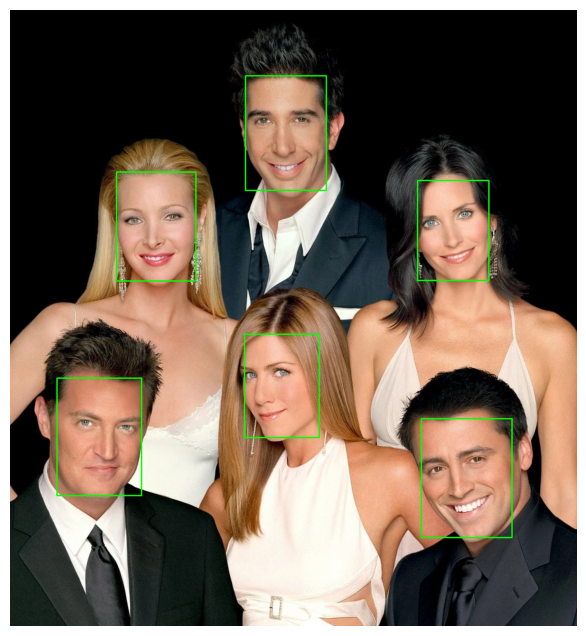

In [38]:
detector = MTCNN()
faces_detected = []

for img_path in img_paths:
    # Ler imagem
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detectar faces com MTCNN
    results = detector.detect_faces(img_rgb)
    print(f"{len(results)} faces detectadas em {img_path}")

    # Desenhar caixas e salvar faces
    for r in results:
        x, y, w, h = r['box']
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = x1 + w, y1 + h
        face = img_rgb[y1:y2, x1:x2]
        face = cv2.resize(face, (224, 224))
        faces_detected.append(face)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)

    # Mostrar imagem com caixas
    plt.figure(figsize=(10,8))
    plt.axis("off")
    plt.imshow(img_rgb)
    plt.show()


In [39]:
embeddings = []

for face in faces_detected:
    embedding = DeepFace.represent(face, model_name="Facenet")[0]["embedding"]
    embeddings.append(embedding)

print(f"{len(embeddings)} embeddings gerados.")


25-09-14 19:59:43 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 125MB/s]


6 embeddings gerados.


In [45]:
# Ajuste os nomes conforme suas imagens
labels = ["Chandler", "Rachel", "Monica", "Phoebe", "Joey", "Ross"]  # repita nomes se houver mais faces da mesma pessoa

# Codificar labels
out_encoder = LabelEncoder()
out_encoder.fit(labels)
labels_enc = out_encoder.transform(labels)


In [46]:
# Normalizar embeddings
in_encoder = Normalizer(norm='l2')
embeddings_norm = in_encoder.transform(embeddings)

# Treinar SVM
model = SVC(kernel='linear', probability=True)
model.fit(embeddings_norm, labels_enc)

print("Classificador SVM treinado com sucesso!")


Classificador SVM treinado com sucesso!


In [47]:
with open("svm_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(out_encoder, f)
with open("normalizer.pkl", "wb") as f:
    pickle.dump(in_encoder, f)

data_to_save = {"embeddings": embeddings, "labels": labels}
with open("face_embeddings.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

print("Modelo, encoders e embeddings salvos com sucesso!")


Modelo, encoders e embeddings salvos com sucesso!


In [48]:
with open("svm_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("label_encoder.pkl", "rb") as f:
    loaded_encoder = pickle.load(f)
with open("normalizer.pkl", "rb") as f:
    loaded_normalizer = pickle.load(f)
with open("face_embeddings.pkl", "rb") as f:
    loaded_data = pickle.load(f)

print("Modelo, encoders e embeddings carregados com sucesso!")


Modelo, encoders e embeddings carregados com sucesso!


Saving Friends.png to Friends (3).png


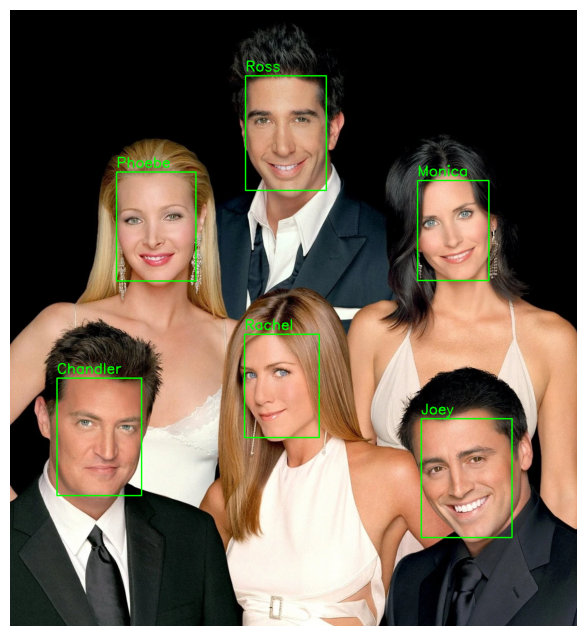

In [49]:
def predict_faces(loaded_model, loaded_encoder, loaded_normalizer):
    uploaded_test = files.upload()
    test_path = list(uploaded_test.keys())[0]

    # Ler imagem
    test_img = cv2.imread(test_path)
    test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Detectar faces com MTCNN
    detector = MTCNN()
    results_test = detector.detect_faces(test_rgb)

    for r in results_test:
        x, y, w, h = r['box']
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = x1 + w, y1 + h
        face = test_rgb[y1:y2, x1:x2]
        face = cv2.resize(face, (224,224))

        # Gerar embedding
        embedding = DeepFace.represent(face, model_name="Facenet")[0]["embedding"]
        embedding_norm = loaded_normalizer.transform([embedding])

        # Prever classe
        pred = loaded_model.predict(embedding_norm)
        pred_name = loaded_encoder.inverse_transform(pred)[0]

        # Desenhar caixa com nome
        cv2.rectangle(test_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(test_rgb, pred_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # Mostrar imagem
    plt.figure(figsize=(10,8))
    plt.axis("off")
    plt.imshow(test_rgb)
    plt.show()

# Chamar a função
predict_faces(loaded_model, loaded_encoder, loaded_normalizer)
